# DSCI 100 006 Group 32 Project Proposal
## Taiwan Housing Prices K Nearest Neighbour Regression Analysis
Jim Geng, Madalyn Stekl, William Kawira, Shikha Rajesh  

## Introduction

Text here

## Data Analysis and Results
#### Preliminary Data Cleaning and Wrangling

In [48]:
set.seed(2023)
# importing libraries

library(readxl)
library(repr)
library(readr)
library(ggplot2)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

To obtain the data, we download a excel spreadsheet from University of California Irvine's data science host server and importing it through the `read_xlsx()` function. 

In [49]:
# file download
house_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"
dest_file <- "data/Real estate valuation data set.xlsx"
download.file(house_url, dest_file)

# read file
house_data <- read_xlsx("data/Real estate valuation data set.xlsx")
house_data

No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2012.917,32.0,84.87882,10,24.98298,121.5402,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.5395,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.5439,47.3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
412,2013.25,18.8,390.96960,7,24.97923,121.5399,40.6
413,2013.00,8.1,104.81010,5,24.96674,121.5407,52.5
414,2013.50,6.5,90.45606,9,24.97433,121.5431,63.9


*Table 1. Initial Taiwanese housing data downloaded from University of California dataset website.*

Next, the data is wrangled, cleaned, and the predictors for the knn regression are selected.

In [50]:
# cleaning column names and removing extraneous columns.
house_data <- house_data |> 
    rename(
        age = "X2 house age",
        station_distance = "X3 distance to the nearest MRT station",
        store_count = "X4 number of convenience stores",
        price_per_unit = "Y house price of unit area"
    ) |>
    select(-c("No", "X1 transaction date", "X5 latitude", "X6 longitude")) |>
    mutate(store_count = store_count)
house_data

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
32.0,84.87882,10,37.9
19.5,306.59470,9,42.2
13.3,561.98450,5,47.3
⋮,⋮,⋮,⋮
18.8,390.96960,7,40.6
8.1,104.81010,5,52.5
6.5,90.45606,9,63.9


*Table 2. Cleaned and wrangled version of the Taiwanese housing data, with unused columns removed and column names renamed for analysis.*

In [51]:
set.seed(2023)
# splitting data into training and testing sets.
house_split <- initial_split(house_data, prop = 0.75, strata = price_per_unit)
house_train <- training(house_split)
house_test <- testing(house_split)

The data can then be summarized, with preliminary visualizations generated to help identify any intial qualitative observations on the data.

In [52]:
# summary statistics
house_train_mean <- house_train |>
    summarize(across(age:price_per_unit, mean))
house_train_mean

age,station_distance,store_count,price_per_unit
<dbl>,<dbl>,<dbl>,<dbl>
17.55032,1059.566,4.159091,38.20779


*Table 3. Summary table describing the mean value of each column.*

Our data does not have any missing values, nor does it have any discrepancies in the amount of observations in each class, so here we have printed out the mean of each predictor variable. Paired with visualizations and values from the original dataset, this allows for easier identification of potential outlier values when compared with these mean values.

#### Preliminary Data Exploration

Some preliminary visualizations we can create are various scatterplots plotting our chosen predictor variables vs. the house price. This will establish some general hints as to whether or not there are strong enough relationships between the variables to use them for our regression analysis.

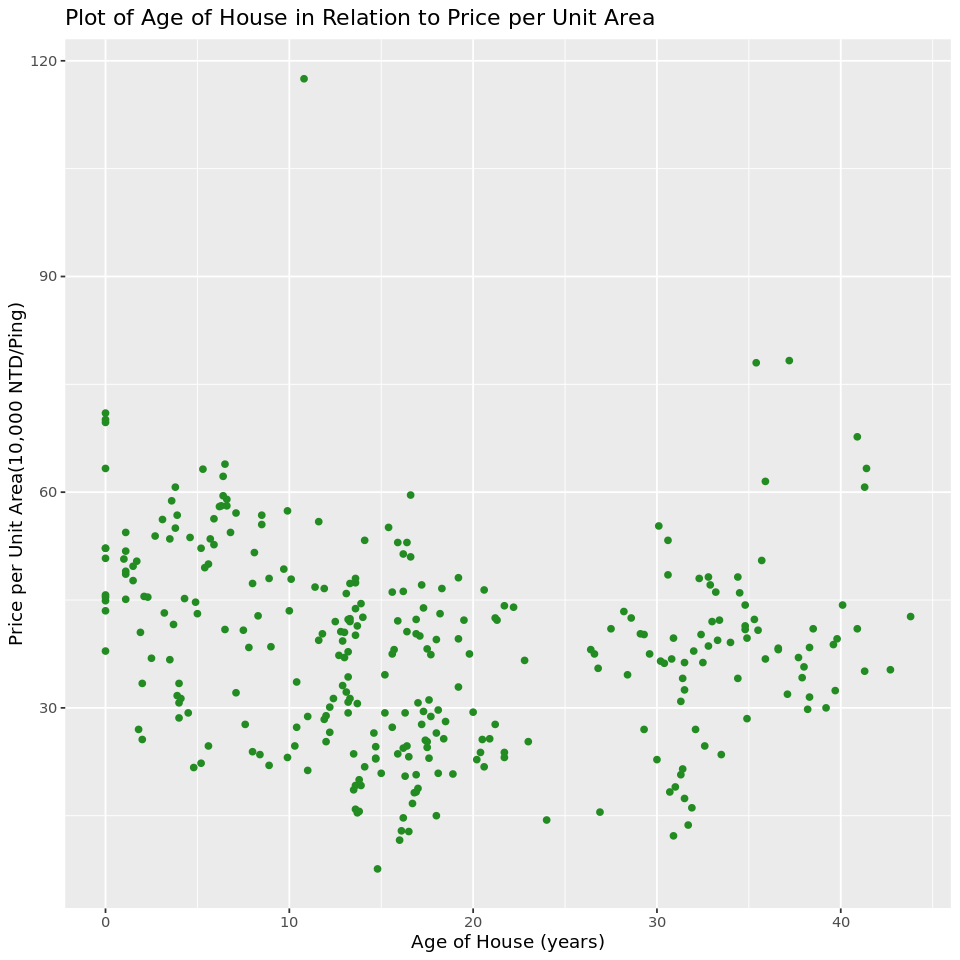

In [53]:
options(repr.plot.width = 8, repr.plot.height = 8)

# age vs price scatterplot
age_price_plot <- house_train |> 
    ggplot(aes(x = age, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Age of House (years)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 18)) + 
    ggtitle("Plot of Age of House in Relation to Price per Unit Area")
age_price_plot

*Figure 1. Plot of the relationship between the age of the residence and its price per unit area.*

This scatterplot shows that the age of house and price may not have a strong correlation. The data has a slightly negative correlation at first that flattens out as the age of house increases. There are also outlier data points with four houses at the 35-40 years old range.

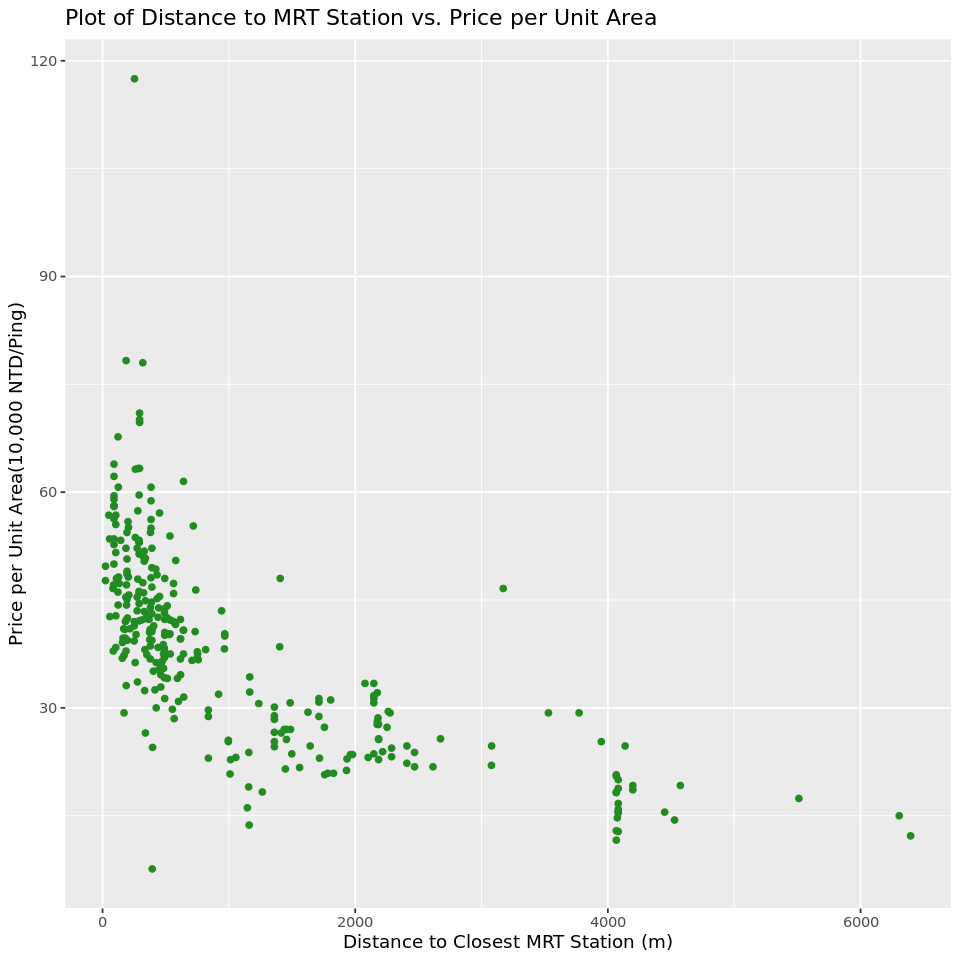

In [54]:
# distance to station vs price scatterplot
station_price_plot <- house_train |> 
    ggplot(aes(x = station_distance, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Distance to Closest MRT Station (m)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    ggtitle("Plot of Distance to MRT Station vs. Price per Unit Area") +
    theme(text = element_text(size = 18))
station_price_plot

*Figure 2. Plot of the relationship between the house's distance to the closest public transit station and its price per unit area.*

There is noticable negative correlation between the distance to closest MRT (public transportation) station, and KNN regression has the potential to be useful here since the correlation does not seem to be completely linear. 

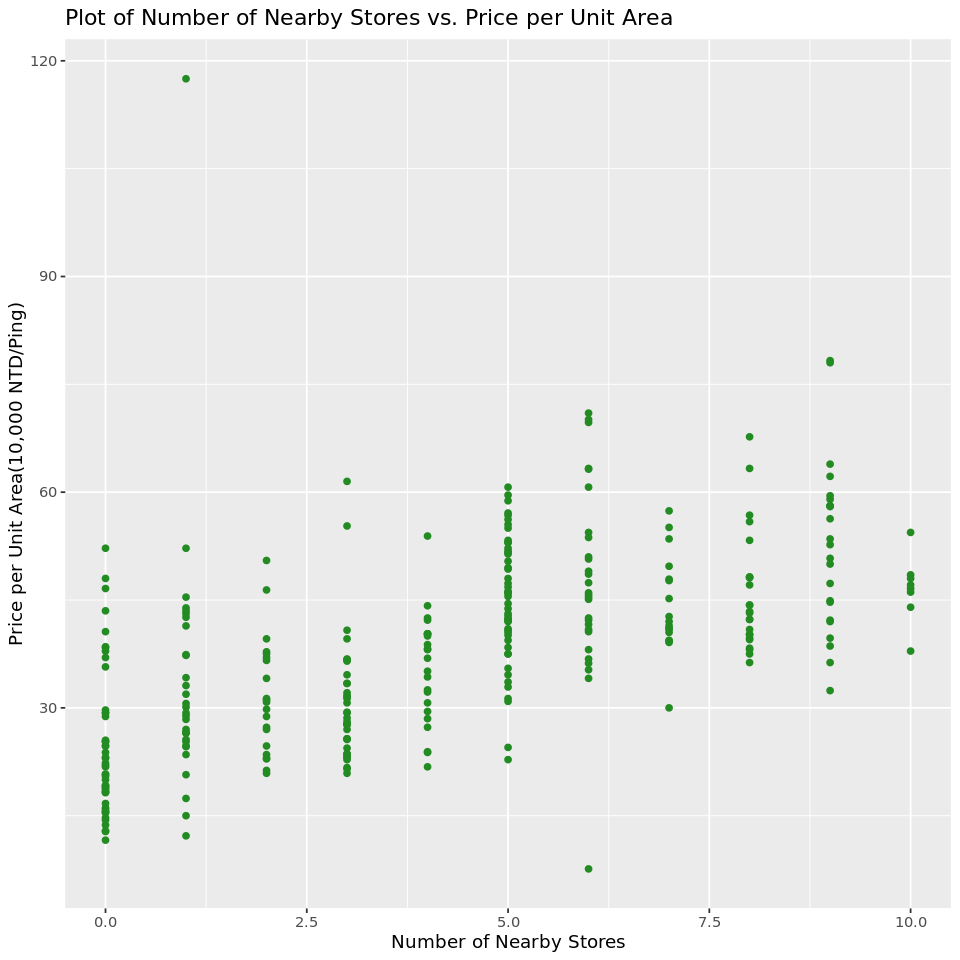

In [55]:
# num of nearby stores vs price scatterplot
store_price_plot <- house_train |> 
    ggplot(aes(x = store_count, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    labs(x = "Number of Nearby Stores", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 18)) +
    ggtitle("Plot of Number of Nearby Stores vs. Price per Unit Area")
store_price_plot

*Figure 3. Plot of the relationship between the number of nearby convenenience stores of the house and its price per unit area.*

This figure shows a moderately strong postive correlation between the number of nearby stores and the price of housing. The correlation seems to be fairly linear. This indicates that a linear regression model could be an alternative approach in the future if another different regression model is completed with only number of nearby stores used as a singular predictor. However, for the sake of doing a multivariable regression we will apply KNN regression with all of the predictors since KNN fits the other predictors more.

#### KNN Model Tuning

Next, we will tune the model based off of the training data with v-fold cross validation. We will test K values from 1 to 100.

In [56]:
set.seed(2023)
# V-Fold Function
house_vfold <- vfold_cv(house_train, v = 5, strata = price_per_unit)

# Number of K Neighbours to test
gridvals <- tibble(neighbors = seq(1,100))

# KNN Model
house_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# Regression recipe
house_recipe <- recipe(price_per_unit ~ ., data = house_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Tuning step
house_tune_results <- workflow() |> 
    add_recipe(house_recipe) |> 
    add_model(house_spec) |> 
    tune_grid(resamples = house_vfold, grid = gridvals) |> 
    collect_metrics()

# Tuning result table, uncomment to view
# house_tune_results

# Finding minimum rmse
house_tune_min <- house_tune_results |> 
    filter(.metric == "rmse") |> 
    arrange(mean) |> 
    head(4)

house_tune_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,rmse,standard,9.172155,5,0.9662820,Preprocessor1_Model015
16,rmse,standard,9.175129,5,0.9780684,Preprocessor1_Model016
12,rmse,standard,9.176345,5,0.9654732,Preprocessor1_Model012
14,rmse,standard,9.176514,5,0.9630439,Preprocessor1_Model014


*Table 4. V-fold cross validation results showcasing the first four K values with the lowest RMSE values.*

Here, with vfold cross validation done with k = 1 to 100, it is revealed that k = 15 gave the minimum rmse value. This can be further supported by the following line plot.

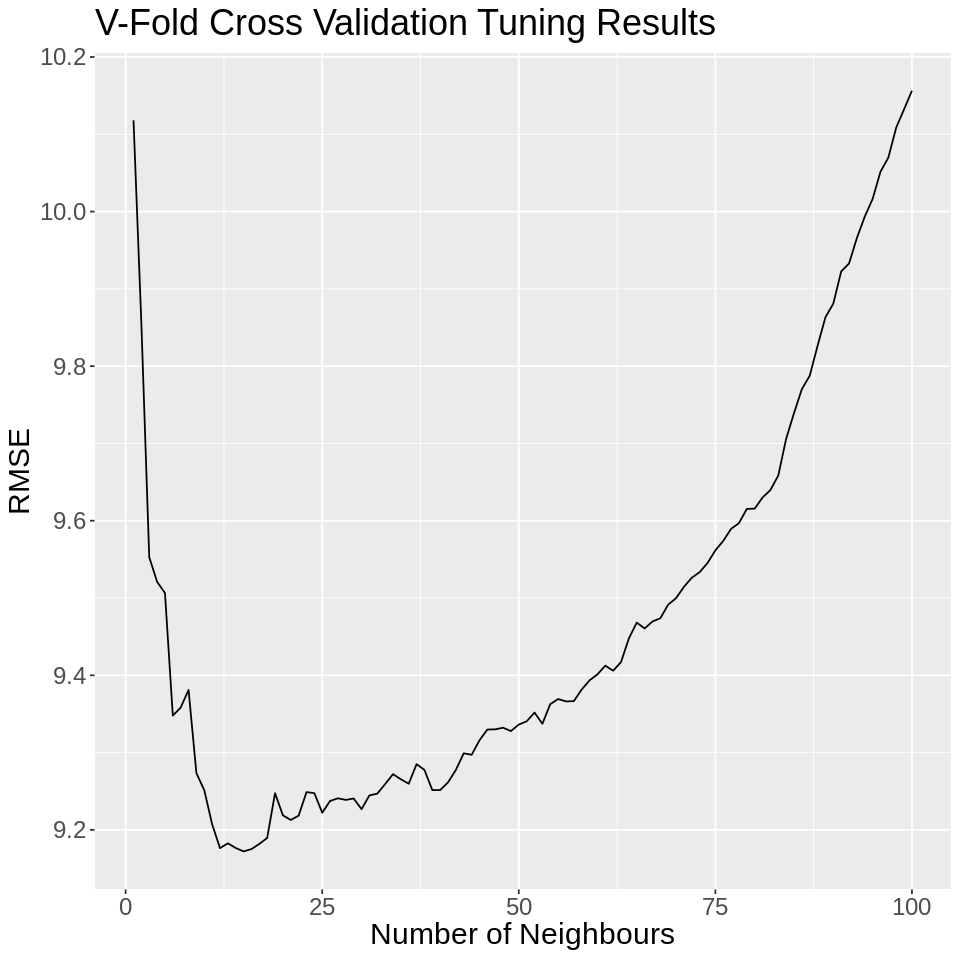

In [58]:
house_tune_plot <- house_tune_results |> 
    filter(.metric == "rmse") |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_line() +
        xlab("Number of Neighbours") +
        ylab("RMSE") +
        ggtitle("V-Fold Cross Validation Tuning Results") +
        theme(text = element_text(size = 18))

house_tune_plot

*Figure 4. V-fold cross validation results showing the minimum rmse value tuned by testing K values from 1 to 100.* 

With the optimal k-value, the multivariable KNN regression can now be performed.

#### KNN Model Fitting

In [59]:
set.seed(2023)

# Extracting best K value
k_min <- house_tune_min |> 
    head(1) |>
    pull(neighbors)

# Creating a new model based on the best K value
house_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |> 
    set_engine("kknn") |> 
    set_mode("regression")

# New model with the optimal K value
house_best_fit_results <- workflow() |> 
    add_recipe(house_recipe) |> 
    add_model(house_best_spec) |> 
    fit(data = house_train)

house_preds <- house_best_fit_results |> 
    predict(house_test) |>
    bind_cols(house_test)

house_summary <- house_preds |>
    metrics(truth = price_per_unit, estimate = .pred)

house_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,7.8311030
rsq,standard,0.6271196
mae,standard,5.8044025


This summary table shows that the overall RMSPE value of our KNN regression model is around 8.378 price per unit area.

#### KNN Model Visualization

We can now visualize KNN predictions by plotting a line plot in comparison with scatterplot of the testing data.

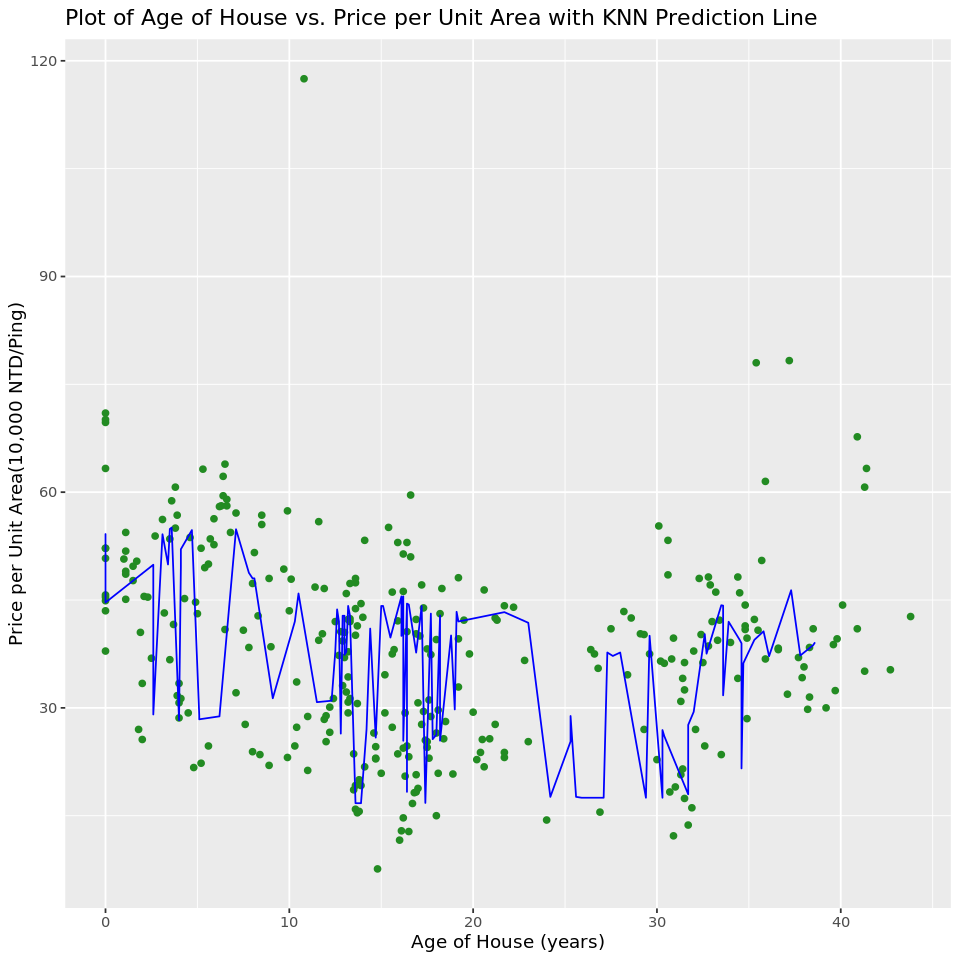

In [62]:
age_price_plot <- house_train |> 
    ggplot(aes(x = age, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    geom_line(
        data = house_preds,
        mapping = aes(x = age, y = .pred),
        color = "blue") +
    labs(x = "Age of House (years)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 18)) + 
    ggtitle("Plot of Age of House vs. Price per Unit Area with KNN Prediction Line")
age_price_plot

*Figure 5. Plot of the relationship between the house's distance to the closest public transit station and its price per unit area of the testing data, overlayed with KNN prediction line*

### TODO: TALK ABOUT NON EXISTANT RELATIONSHIP HERE

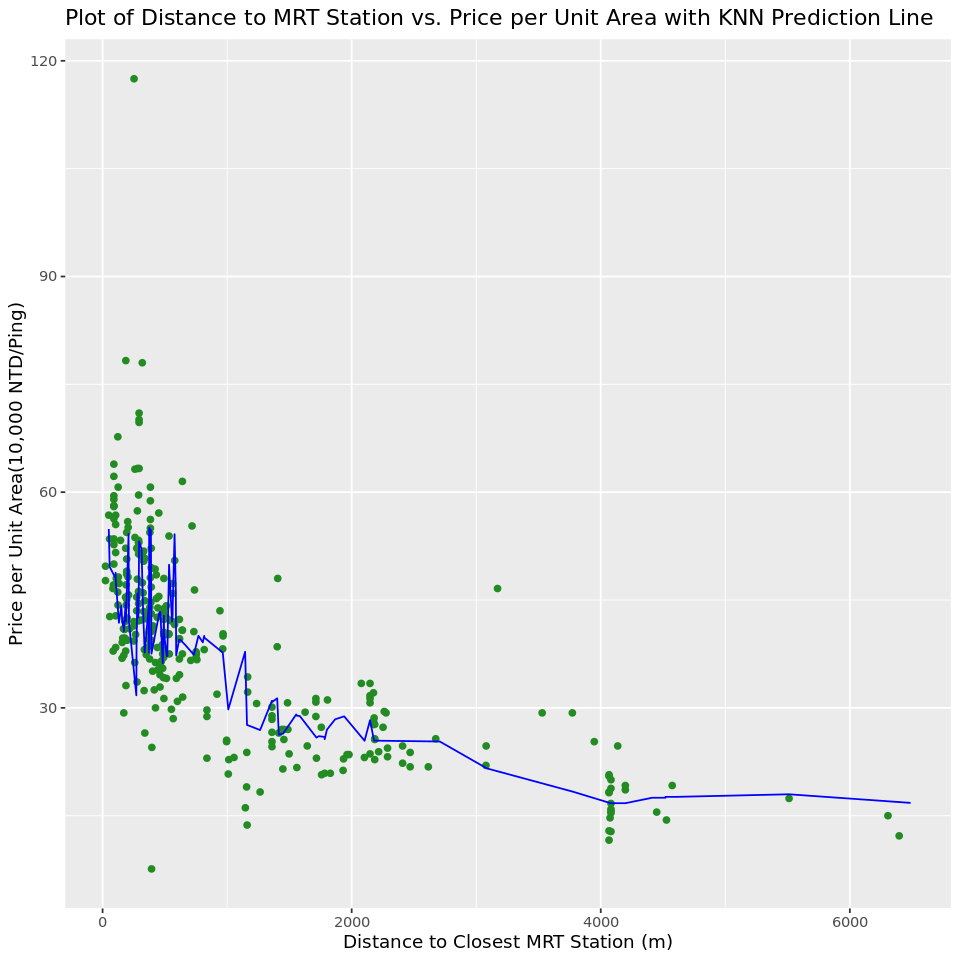

In [64]:
station_price_plot <- house_train |> 
    ggplot(aes(x = station_distance, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    geom_line(
        data = house_preds,
        mapping = aes(x = station_distance, y = .pred),
        color = "blue") +
    labs(x = "Distance to Closest MRT Station (m)", y = "Price per Unit Area(10,000 NTD/Ping)") +
    ggtitle("Plot of Distance to MRT Station vs. Price per Unit Area with KNN Prediction Line") +
    theme(text = element_text(size = 18))
station_price_plot

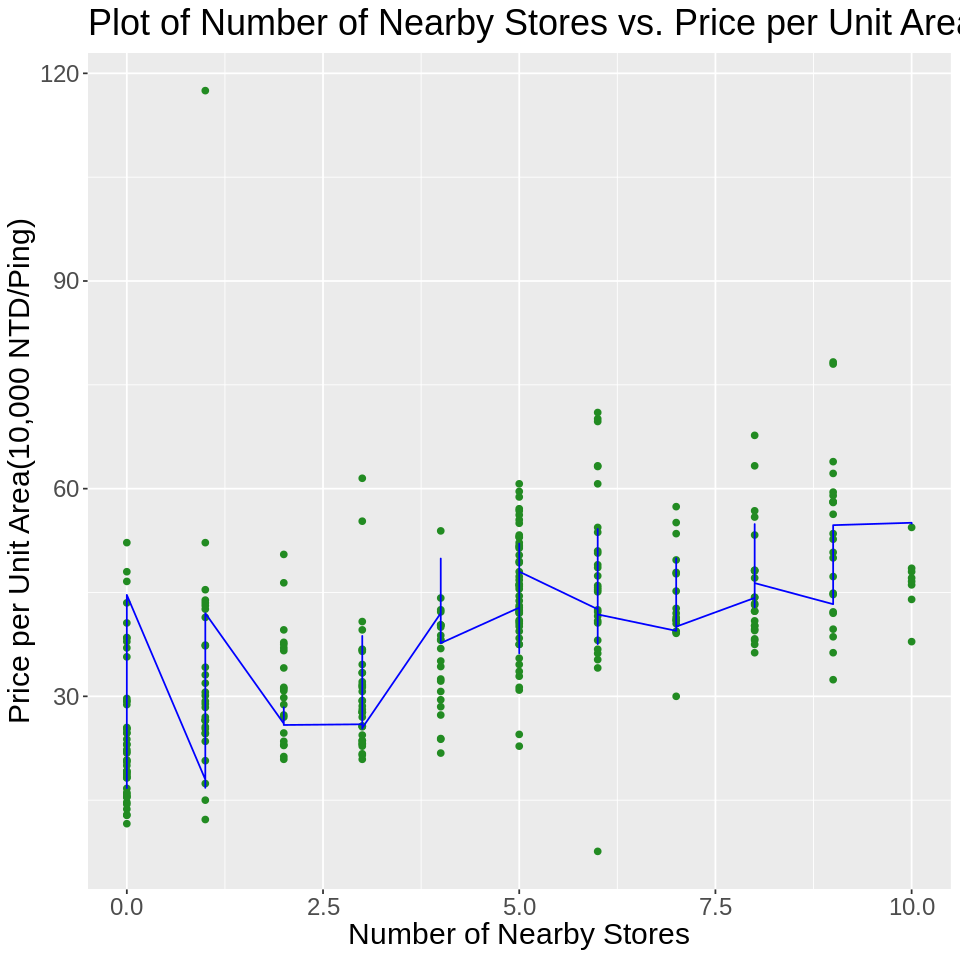

In [65]:
store_price_plot <- house_train |> 
    ggplot(aes(x = store_count, y = price_per_unit)) +
    geom_point(col = "forestgreen") +
    geom_line(
        data = house_preds,
        mapping = aes(x = store_count, y = .pred),
        color = "blue") +
    labs(x = "Number of Nearby Stores", y = "Price per Unit Area(10,000 NTD/Ping)") +
    theme(text = element_text(size = 18)) +
    ggtitle("Plot of Number of Nearby Stores vs. Price per Unit Area")
store_price_plot